<a href="https://colab.research.google.com/github/devorahst/Test/blob/main/Logistic_Regression_and_Machine_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of Factors that Influence the Likelihood a RapeKit Sample will Produce a Profile Eligible for Use in Law Enforcement and Criminal Justice

#Set Up

##Import relevant libraries

In [ ]:
import statsmodels.api as sm
import pandas as pd  
import numpy as np
from patsy import dmatrices

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

## Part 1. Upload
First, we must download the dataset. Upon running the cell, you will be prompted to login to your Gmail account. You will then be provided with a one-time use code to copy and paste into the slot below. After hitting enter, the dataset will load into this script.

In [ ]:
#pulls up our SAK dataset
#@title uploader
file_id = "1lMSXIdMUQTZVOOk2wG-1awvPEIlypfxV" #@param {type:"string"}
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  _, done = downloader.next_chunk()

fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

DataFrame_corrected.csv


## Part 2. Set Up
1. Install and Import - Install SciKit-Learn and import necessary packages
2. Clean the Dataset - Label the columns and replace null values with "No Response" and sort features based on type.
3. Display Cleaned Dataset

###1. Install and Import

In [ ]:
pip install -U scikit-learn

     |████████████████████████████████| 24.8 MB 35.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [ ]:
from scipy.stats import chi2_contingency
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})


###2. Read in File and Clean the Dataset



#####**Label the columns and replace null values with "No Response"**


In [ ]:
with open(fileId['title'], encoding="utf8", errors='ignore') as f:
  df = pd.read_csv(f)

df = df.astype('string')
df = df.replace(r'^\s+$', np.nan, regex=True)
df = df.replace({np.nan: "No Response"})

df = df[df['ProfileofSTRDNAloci'] != "No Response"]
df = df[df['CODISNDISeligibleProfile'] != "No Response"]

df = df[df['Site'] != '6'] #filter out other state data
df = df[df['Gender'] == '1']  #dataframe containing information from only female respondents

#Add col showing STRDNA profile eligible/not eligible
def makeContingency(row):
  good_values = ['1','2']  
  eligibility = row["ProfileofSTRDNAloci"]
  if eligibility in good_values:
    return "1"
  else:
    return "0"


df['STRDNAEligible'] = df.apply(makeContingency, axis=1)

predictedVariable = "STRDNAEligible"

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,9,239,240,255,257,258,261,269,283,285,290,294,301,313) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#####**Sort Features Based on Type**
Because our features are not all categorical, we cannot calculate each feature's p-value using the same method. We must sort our features into numerical, categorical, and string entries and then apply the correct method to obtain each p-value. For categorical features, we will run chi-square tests while we will use analysis of variance (ANOVA) with T-Testing for numerical features. The meaning of the variables are all described in the [code book](https://drive.google.com/file/d/18PDTuK0lshc193lXA3b7UDgcRzMoEEGA/view?usp=sharing).

In [ ]:
predictedFeatures = ['CODISNDISeligibleProfile', 'SDISeligibleprofile']  

numericalFeatures = ['Age', 'Timebetweenassaultandexaminhours', 'PainLevel', 'MulitipleSuspectNumber', 
                     'NumberofUnknownresponses', 'NumberAssaultiveActs', 'Numberofphysicalinjuries', 'Numberofgentialinjuries',
                     'NumberOFitemsTested', 'TimeBetweenCollectAndDNAext', 'TimeBetweenSubmissionANDtesting', 'NumberOfswabsQuantMaleDNA',
                     'NumberOfswabsDNAanalysis', 'NumberofSTRDNAloci', 'NumberOFswabsSTRDNAprofile', 'NumberOfYSTRDNAloci']

categoricalFeatures = ['Site', 'EXAMbySANE', 'YearKitCollected', 'KITbroughtTOcrimelab', 'KITlengthofSubmissionTime',
                       'UnderAge18', 'Gender', 'ExamDeclined', 'Noninterview', 'Race', 'PriorHxofSAover14',
                       'PriorHxofSAunder14', 'Student', 'Military', 'Pain', 'PainLocation1','PainLocation2', 
                       'PainLocation3', 'PainLocation4','PainTreatment', 'PermanentAddress', 'CurrentPhysicalmedprob',
                       'MedProbChronic', 'MedProbInfection', 'MedProbBlood', 'MedProbCardiac', 'MedProbEar', 'MedProbEndocrine',
                       'MedProbEye', 'MedProbGI', 'MedProbGU', 'MedProbGYN', 'MedProbImmune', 'MedProbMusculoskeletal', 'MedProbNeurological',
                       'MedProbOral', 'MedProbRenal', 'MedProbRespiratory', 'MedProbSkin', 'MedProbOther', 'Medication',
                       'PsychotropicMEDuse', 'PsychotropicANTIPSYCHOTICSatypical', 'PsychotropicSTIMULANTuse', 'PsychotropicANTIANXIETY', 
                       'PsychotropicANTIDEPRESSANTS', 'PsychotropicANTISEIZUREbipolar', 'PsychotropicADDICTIONmeds','PsychotropicSLEEPaid', 'PsychotropicOTHER', 
                       'PsychotropicANTIPSYCHOTICStypical', 'PolypharmacyPsychMeds', 'ImmunizationstatusTETANUS', 'ReceivedTetanus',
                       'ImmunizationstatusHEP', 'ReceivedHepB', 'Sexualcontactwithin120hours', 'Selfdisclosurementalillness', 'MIdepression',
                       'MIanxiety', 'MIPTSD', 'MIpsychoticDisorders', 'MIadhd', 'MIpersonalitydisorder', 'MIbipolar', 'MIeatingdisorder', 'MIdrugalcoholdisorders', 
                       'MIother', 'SelfDiscolsureMentalillnessORuseofpsychotropics', 'OnlineMeetingOFsuspect', 'Suspectrelationship',
                       'Locationofassault', 'PatientActionScratch', 'PatientActionBite', 'PatientActionHit', 'PatientActionKick', 'PatientActionOther',
                       'Suspectrace', 'SuspectactionVERBAL', 'SuspectactionsGRABBEDHELD', 'SuspectactionsPHYSICALBLOWS', 'SuspectactionsSTRANGLEDCHOKED',
                       'SuspectactionsWEAPON', 'SuspectactionsRESTRAINTS', 'SuspectactionsBURNED', 'MultipleSuspects', 'SuspectedDrugfacilitated',
                       'Patientdruguse', 'PatientETOHuse', 'Suspectdruguse', 'SuspectETOHuse', 'PatientSuspectETOHordrug', 'LossOFconsciousnessORawareness',
                       'OneORmoreunknownanswer', 'Unknownanswerto4ormorequestions', 'UnknownanswertoALL', 'AsleepANDawakenedtoassault', 'MemoryLoss',
                       'LossOfconsciousness', 'DecreasedAwareness', 'TonicImmobility', 'Detachment', 'NOSApatientsVAGINApenis', 'NOSApatientsVAGINAfingerhand',
                       'NOSApatientsVAGINAmouth', 'NOSApatientsVAGINAobject', 'NOSApatientsANUSpenis', 'NOSApatientsANUSfingerhand', 'NOSApatientsANUSmouth', 
                       'NOSApatientsANUSobject', 'NOSApatientsPENISgenitals', 'NOSApatientsPENISfinger', 'NOSApatientsPENISmouth', 'NOSApatientsPENISobject', 
                       'NOSApatientsMOUTHpenis', 'NOSApatientsMOUTHfinger', 'NOSApatientsMOUTHmouth', 'NOSApatientsMOUTHobject', 'SUSPECTmouthcontactGENITALS', 
                       'SUSPECTmouthcontactMOUTH', 'SUSPECTmouthcontactOTHER', 'SUSPECTmouthcontactOTHERsite', 'HANDSofSuspectBreast', 'HANDSofSuspectExtremities', 
                       'HANDSofSuspectOther', 'Ejaculation', 'CONDOMuse', 'LUBRICATIONuse', 'SuspectWASHEDpatient', 'SuspectINJUREDbypatient', 'PostassaultURINATED', 
                       'PostassaultDEFECATED', 'PostassaultDOUCHED', 'PostassaultVOMITED', 'PostassaultGARGLED', 'PostassaultBRUSHEDTEETH', 'PostassaultATEdrank', 
                       'PostassaultBATHED', 'PostassaultGENITALWIPE', 'PostassaultCHANGEDCLOTHING', 'PostassaultREMOVEDInserted', 'PhysicalORmentalimpairment', 'Physicalinjury', 
                       'LPIhead', 'LPIneck', 'LPIbreasts', 'LPIchestback', 'LPIabdomen', 'LPIextremities', 'TPIlaceration', 'TPIecchymosis', 'TPIabrasion', 'TPIredness', 
                       'TPIswelling', 'TPIbruise', 'TPIpetechiae', 'TPIincision', 'TPIavulsion', 'TPIdiscoloredmark', 'TPIpuncturewound', 'TPIfracture', 
                       'TPIbitemark', 'TPIburn', 'TPImissingorbrokenTEETH', 'TPIconjunctivalhemorrhage', 'Genitalinjury', 'LGIinnerthighs', 'LGIclitoralhoodclitoris', 
                       'LGIlabiamajora', 'LGIlabiaminora', 'LGIperiurethraltissueURETHRA', 'LGIperihymenaltissue', 'LGIhymen', 'LGIvagina', 'LGIcervix', 'LGIfossanavicularis', 
                       'LGIposteriorfourchette', 'LGIperineum', 'LGIperineum', 'LGIanalrectal', 'LGIbuttocks', 'LGImalePerianalperineum', 'LGIglanspenis', 'LGIpenileshaft', 
                       'LGImaleURETHRALmeatus', 'LGIscrotum', 'LGItestes', 'LGImaleanus', 'LGImalerectum', 'TGIlaceration', 'TGIecchymosis', 'TGIabrasion', 'TGIredness', 
                       'TGIswelling', 'TGIbruise', 'TGIpetechiae', 'TGIincision', 'TGIavulsion', 'TGIdiscoloredmark', 'TGIpuncturewound', 'ToludineDYEuptake', 'HIVnPEP', 
                       'UQuikcollected', 'Yscreen', 'NumberItemsWITH3cutoff', 'ItemsAnalyzed1', 'ItemsAnalyzed2', 'ItemsAnalyzed3', 'ItemsAnalyzed4', 'ItemsAnalyzed5', 
                       'ItemsAnalyzed6', 'ItemsAnalyzed7', 'ItemsAnalyzed8', 'ItemsAnalyzed9', 'ItemsAnalyzed10', 'TypesOFitemsTested', 'RandomSample20142015', 
                       'YearofDNAextraction', 'LocationOfTesting','DANYfundedSAK', 'DNAKitUsed', 'SerologyDoneBeforeDNA', 'QuantMaleDNAFound', 'QuantMaleSwabLoc1', 
                       'QuantMaleSwabLoc2', 'QuantMaleSwabLoc3', 'QuantMaleSwabLoc4', 'QuantMaleSwabLoc5', 'ProbableSTRDNAprofileOFsuspect', 'ProfileofSTRDNAloci', 'ProbableYSTRDNAprofile', 'ProfileOfYSTRDNAloci', 
                       'SwabLocationYSTRDNA', 'SecondSwabLocationYSTRDNA', 'SwabFromSuspectwithVictimDNA', 'ExcludeSuspect', 'ConsensualPartnerStandardSubmitted', 
                       'STRDNAProbableprofileTYPE', 'CODISprofileHit', 'STRDNAkitUsed', 'SUSPECTmouthcontactBREASTS', 'Swab1LocationSTRDNAprofile', 'Swab2LocationSTRDNAprofile',
                       'Swab3LocationSTRDNAprofile', 'SuspectStandardSubmitted', 'CODISNDISreasons', 'CODISSDISreasons']
swabToDNAFeatures = ['Swab1ToDNAanalysis', 'Swab2ToDNAanalysis', 'Swab3ToDNAanalysis', 'Swab4ToDNAanalysis']
#unusedFeatures and stringFeatures are columns that contain data that was relevant to medical professionals and for legal purposes, 
#but that aren't useful for our feature association or for predicting eligibility
unusedFeatures = ['filter_$', 'PainTreatmentYesNo', 'GenderMaleFemale', 'DVsuspect', 'RacePrimaryGroups', 'IPSAcombined', 'STRDNAcompleted', 
                  'PhysicalInjuryNOunknown', 'GenitalInjuryNOunknown']

stringFeatures = ['DeIdentifiedCase', 'Raceother', 'SchoolName', 'MilitaryBranchName', 'AddressIfnotPermanent', 'Currentmedprobtext',
                  'MedProbOtherText', 'Medicationtext', 'Sexualcontactwithin120hoursTYPE', 'SelfdisclosureMItype', 'OnlineMeetingName', 'SuspectrelationshipOTHER',
                  'LocationofassaultOTHER', 'Surfaceofassault', 'PatientActionOtherTEXT', 'SuspectraceOTHER', 'SuspectOTHERactions', 'NOSApatientsVAGINAobjectdescription',
                  'NOSApatientsANUSobjectdescription', 'NOSApatientsPENISobjectdescription', 'NOSApatientsMOUTHobjectdescription', 'EjaculationSITE', 'LUBRICATIONtype',
                  'SuspectINJUREDbypatientexplanation', 'Impairmentdescription', 'UBFSnumber', 'ISPnumber', 'DateSubmittedUBFS', 'DateofDNAextractionReport',
                  'BodySwabLocQuant', 'BodySwabDNAanalysis', 'BodySwabLocationSTRDNA', 'BodySwabYSTRDNA', 'ISPnotes2020', 'UBFSnotes2020', 'UBFSnotes2018', 'UBFSnotes2014']

In [ ]:
df

,DeIdentifiedCase,Site,EXAMbySANE,YearKitCollected,KITbroughtTOcrimelab,KITlengthofSubmissionTime,Age,UnderAge18,Gender,ExamDeclined,Noninterview,Timebetweenassaultandexaminhours,Race,Raceother,PriorHxofSAover14,PriorHxofSAunder14,Student,SchoolName,Military,MilitaryBranchName,Pain,PainLevel,PainLocation1,PainLocation2,PainLocation3,PainLocation4,PainTreatment,PermanentAddress,AddressIfnotPermanent,CurrentPhysicalmedprob,Currentmedprobtext,MedProbChronic,MedProbInfection,MedProbBlood,MedProbCardiac,MedProbEar,MedProbEndocrine,MedProbEye,MedProbGI,MedProbGU,...,SecondSwabLocationYSTRDNA,BodySwabYSTRDNA,SwabFromSuspectwithVictimDNA,ExcludeSuspect,SuspectStandardSubmitted,ConsensualPartnerStandardSubmitted,CODISNDISeligibleProfile,SDISeligibleprofile,STRDNAProbableprofileTYPE,CODISprofileHit,ISPnotes2020,UBFSnotes2020,UBFSnotes2018,UBFSnotes2014,filter_$,PainTreatmentYesNo,GenderMaleFemale,DVsuspect,RacePrimaryGroups,IPSAcombined,STRDNAcompleted,PhysicalInjuryNOunknown,GenitalInjuryNOunknown,CODISNDISreasons,CODISSDISreasons,STRDNAkitUsed,ProfileofSTRDNAloci,SwabToDNAanalysisNoquantmaleDNAfound,SwabToDNAanalysisVaginal,SwabToDNAanalysisCervical,SwabToDNAanalysisPerianal,SwabToDNAanalysisRectal,SwabToDNAanalysisOral,SwabToDNAanalysisBody,SwabToDNAanalysisUnderwear,SwabToDNAanalysisOtherClothing,SwabToDNAanalysisBedding,SwabToDNAanalysisCondom,SwabToDNAanalysisTampon,STRDNAEligible
0,FT988320,1,1,1,1,1,17,1,1,0,No Response,48,3,No Response,4,4,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,0,No Response,0,0,0,0,0,0,0,0,0,...,No Response,No Response,0,0,0,0,1,1,1,0,No Response,No Response,DNA report found 5/16/19.,Left message for detective requesting standard...,0,No Response,1,No Response,3,2,1,1,1,1,1,2,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,LZ866552,1,1,1,1,2,27,0,1,0,No Response,3,2,No Response,4,4,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,0,No Response,0,0,0,0,0,0,0,0,0,...,No Response,No Response,0,0,0,0,0,0,3,4,No Response,No Response,DNA report found 5/16/19.,Detective said no DNA analysis is needed at th...,0,No Response,1,No Response,2,1,1,1,0,4,4,2,4,0,0,0,0,0,0,1,0,0,0,0,0,0
2,FT988772,1,1,1,1,1,23,0,1,0,No Response,6,1,No Response,4,4,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,0,No Response,0,0,0,0,0,0,0,0,0,...,No Response,No Response,0,0,0,0,1,1,1,0,No Response,No Response,DNA report found 5/16/19.,"Detective was called with results, no call bac...",0,No Response,1,No Response,1,2,1,1,1,1,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,UM632222,1,1,1,1,1,19,0,1,0,No Response,14,1,No Response,4,4,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,1,"Asthma, mono",1,1,1,0,0,0,0,0,0,...,No Response,No Response,0,0,0,0,1,1,1,0,No Response,No Response,DNA report found 5/16/19.,"Vaginal, perianal, breast, neck and chest swab...",0,No Response,1,No Response,1,2,1,1,1,1,1,2,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,TT976221,1,1,1,1,1,16,1,1,0,No Response,23,1,No Response,4,4,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,1,Strep throat,0,1,0,0,0,0,0,0,0,...,No Response,No Response,0,0,0,0,0,0,No Response,4,No Response,No Response,DNA report found 5/16/19.,"No male DNA found, no further testing done",0,No Response,1,No Response,1,1,No Response,1,0,5,5,No Response,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

##Name and Clean the Variables for Use

**Examine and Clean variables for use**

In [ ]:
df = df.apply(pd.to_numeric, errors='ignore')

In [ ]:
df = df.astype({'Site': int, 'EXAMbySANE': int, 'YearKitCollected': int, 'KITbroughtTOcrimelab': int, 'KITlengthofSubmissionTime': int, 'Age': str, 'UnderAge18': int, 'Gender': int, 'ExamDeclined': bool, 'Noninterview': bool, 'Timebetweenassaultandexaminhours': str, 'Race': int, 'Raceother': int, 'PriorHxofSAover14': bool, 'PriorHxofSAunder14': bool, 'Student': bool, 'SchoolName': str, 'Military': bool, 'MilitaryBranchName': str, 'Pain': bool, 'PainLevel': int, 'PainLocation1': int, 'PainLocation2': int, 'PainLocation3': int, 'PainLocation4': int, 'PainTreatment': bool}, errors='ignore') 

In [ ]:
df['Timebetweenassaultandexaminhours_int'] = pd.to_numeric(df['Timebetweenassaultandexaminhours'], errors='coerce')

def makeContingency(row):
  value = row["Timebetweenassaultandexaminhours_int"]
  if value < 23:
    return "0"
  elif value < 47:
    return "1"
  elif value < 71:
    return "2"
  elif value < 95:
    return "3"
  elif value < 119:
    return "4"
  elif value < 900:
    return "5"
  else:
    return "6"

# 0 = "Under 24 hours"
# 1 = "1 Day"
# 2 = "2 Days" 
# 3 = "3 Days"
# 4 = "4 Days"
# 5 = "5+ Days"
# 6 = "nan"

df['timeBetweenAssaultAndExam'] = df.apply(makeContingency, axis=1)
print(df['timeBetweenAssaultAndExam'].value_counts())

df['timeBetweenAssaultAndExam'] = pd.to_numeric(df['timeBetweenAssaultAndExam'], errors='coerce')

0    2813
1     773
2     338
3     209
4     115
5      89
6      66
Name: timeBetweenAssaultAndExam, dtype: int64


In [ ]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
def makeContingency(row):
  value = row["Age"]
  if value < 20:
    return "0"
  elif value < 30:
    return "1"
  elif value < 40:
    return "2"
  elif value < 50:
    return "3"
  elif value < 60:
    return "4"
  else:
    return "6"

df['ageOfVictim'] = df.apply(makeContingency, axis=1)
print(df['ageOfVictim'].value_counts())

df['ageOfVictim'] = pd.to_numeric(df['ageOfVictim'], errors='coerce')

1    1644
0    1263
2     866
3     408
4     155
6      67
Name: ageOfVictim, dtype: int64


In [ ]:
#EIdf=df[['CODISNDISeligibleProfile','PainTreatment','CurrentPhysicalmedprob',	'MedProbChronic',	'MedProbInfection',	'MedProbBlood',	'MedProbCardiac',	'MedProbEar',	'MedProbEndocrine','Age','UnderAge18',	'Gender', 'ExamDeclined',	'Noninterview',	'Timebetweenassaultandexaminhours',	'Race',	'Raceother',	'PriorHxofSAover14',	'PriorHxofSAunder14',	'Student',	'SchoolName',	'Military',	'MilitaryBranchName',	'Pain',	'PainLevel',	'PainLocation1',	'PainLocation2',	'PainLocation3',	'PainLocation4']]	

In [ ]:
#EIdf.dtypes

In [ ]:
#An effort to compare the "first 20 variables" with the ones selected based on recommendations
#EIdf['CODISNDISeligibleProfile'] = pd.to_numeric(EIdf['CODISNDISeligibleProfile'], errors='coerce')
#EIdf['Age'] = pd.to_numeric(EIdf['Age'], errors='coerce')
#EIdf['UnderAge18'] = pd.to_numeric(EIdf['UnderAge18'], errors='coerce')
#EIdf['Gender'] = pd.to_numeric(EIdf['Gender'], errors='coerce')
#EIdf['ExamDeclined'] = pd.to_numeric(EIdf['ExamDeclined'], errors='coerce')
#EIdf['Noninterview'] = pd.to_numeric(EIdf['Noninterview'], errors='coerce')
#EIdf['Timebetweenassaultandexaminhours'] = pd.to_numeric(EIdf['Timebetweenassaultandexaminhours'], errors='coerce')
#EIdf['Race'] = pd.to_numeric(EIdf['Race'], errors='coerce')
#EIdf['Raceother'] = pd.to_numeric(EIdf['Raceother'], errors='coerce')
#EIdf['PriorHxofSAover14'] = pd.to_numeric(EIdf['PriorHxofSAover14'], errors='coerce')
#EIdf['PriorHxofSAunder14'] = pd.to_numeric(EIdf['PriorHxofSAunder14'], errors='coerce')
#EIdf['Student'] = pd.to_numeric(EIdf['Student'], errors='coerce')
#EIdf['SchoolName'] = pd.to_numeric(EIdf['SchoolName'], errors='coerce')
#EIdf['Military'] = pd.to_numeric(EIdf['Military'], errors='coerce')
#EIdf['MilitaryBranchName'] = pd.to_numeric(EIdf['MilitaryBranchName'], errors='coerce')
#EIdf['Pain'] = pd.to_numeric(EIdf['Pain'], errors='coerce')
#EIdf['PainLevel'] = pd.to_numeric(EIdf['PainLevel'], errors='coerce')
#EIdf['PainLocation1'] = pd.to_numeric(EIdf['PainLocation1'], errors='coerce')
#EIdf['PainLocation2'] = pd.to_numeric(EIdf['Painlocation2'], errors='coerce')
#EIdf['PainLocation3'] = pd.to_numeric(EIdf['Painlocation3'], errors='coerce')
#EIdf['PainLocation4'] = pd.to_numeric(EIdf['Painlocation4'], errors='coerce')
#EIdf['PainTreatment'] = pd.to_numeric(EIdf['PainTreatment'], errors='coerce')
#EIdf['CurrentPhysicalmedprob'] = pd.to_numeric(EIdf['CurrentPhysicalmedprob'], errors='coerce')
#EIdf['MedProbChronic'] = pd.to_numeric(EIdf['MedProbChronic'], errors='coerce')
#EIdf['MedProbInfection'] = pd.to_numeric(EIdf['MedProbInfection'], errors='coerce')
#EIdf['MedProbBlood'] = pd.to_numeric(EIdf['MedProbBlood'], errors='coerce')
#EIdf['MedProbCardiac'] = pd.to_numeric(EIdf['MedProbCardiac'], errors='coerce')
#EIdf['MedProbEar'] = pd.to_numeric(EIdf['MedProbEar'], errors='coerce')	
#EIdf['MedProbEndocrine'] = pd.to_numeric(EIdf['MedProbEndocrine'], errors='coerce')

In [ ]:
#EIdf.dtypes

In [ ]:
df['MemoryLoss'] = pd.to_numeric(df['MemoryLoss'], errors='coerce')
df['MulitipleSuspectNumber'] = pd.to_numeric(df['MulitipleSuspectNumber'], errors='coerce')
df['Sexualcontactwithin120hours'] = pd.to_numeric(df['Sexualcontactwithin120hours'], errors='coerce')
df['Ejaculation'] = pd.to_numeric(df['Ejaculation'], errors='coerce')
df['CONDOMuse'] = pd.to_numeric(df['CONDOMuse'], errors='coerce')
df['PostassaultBATHED'] = pd.to_numeric(df['PostassaultBATHED'], errors='coerce')
df['NOSApatientsVAGINApenis'] = pd.to_numeric(df['NOSApatientsVAGINApenis'], errors='coerce')
df['NOSApatientsANUSpenis'] = pd.to_numeric(df['NOSApatientsANUSpenis'], errors='coerce')
df['NOSApatientsMOUTHpenis'] = pd.to_numeric(df['NOSApatientsMOUTHpenis'], errors='coerce')
df['SUSPECTmouthcontactGENITALS'] = pd.to_numeric(df['SUSPECTmouthcontactGENITALS'], errors='coerce')
df['SUSPECTmouthcontactBREASTS'] = pd.to_numeric(df['SUSPECTmouthcontactBREASTS'], errors='coerce')
df['SUSPECTmouthcontactOTHER'] = pd.to_numeric(df['SUSPECTmouthcontactOTHER'], errors='coerce')
df['NOSApatientsVAGINAfingerhand'] = pd.to_numeric(df['NOSApatientsVAGINAfingerhand'], errors='coerce')
df['SuspectactionsSTRANGLEDCHOKED'] = pd.to_numeric(df['SuspectactionsSTRANGLEDCHOKED'], errors='coerce')
df['SuspectactionsPHYSICALBLOWS'] = pd.to_numeric(df['SuspectactionsPHYSICALBLOWS'], errors='coerce')
df['SuspectactionsWEAPON'] = pd.to_numeric(df['SuspectactionsWEAPON'], errors='coerce')
df['Genitalinjury'] = pd.to_numeric(df['Genitalinjury'], errors='coerce')
df['Physicalinjury'] = pd.to_numeric(df['Physicalinjury'], errors='coerce')
df['NumberAssaultiveActs'] = pd.to_numeric(df['NumberAssaultiveActs'], errors='coerce')

In [ ]:
df['Site'] = pd.to_numeric(df['Site'], errors='coerce')

In [ ]:
df['YearKitCollected'] = pd.to_numeric(df['YearKitCollected'], errors='coerce')

In [ ]:
df['KITbroughtTOcrimelab'] = pd.to_numeric(df['KITbroughtTOcrimelab'], errors='coerce')

In [ ]:
df['UnderAge18'] = pd.to_numeric(df['UnderAge18'], errors='coerce')

In [ ]:
df['Race'] = pd.to_numeric(df['Race'], errors='coerce')

In [ ]:
df['MultipleSuspects'] = pd.to_numeric(df['MultipleSuspects'], errors='coerce')

In [ ]:
df['SuspectactionsGRABBEDHELD'] = pd.to_numeric(df['SuspectactionsGRABBEDHELD'], errors='coerce')

In [ ]:
# df2=df.replace({'MemoryLoss':{2:.5}, 
# 'Sexualcontactwithin120hours':{2:.5}, 
# 'Ejaculation':{2:.5}, 
# 'CONDOMuse':{2:.5},
# 'PostassaultBATHED':{2:.5},
# 'NOSApatientsVAGINApenis':{2:.5},
# 'NOSApatientsANUSpenis':{2:.5},
# 'NOSApatientsMOUTHpenis':{2:.5}, 
# 'SUSPECTmouthcontactGENITALS':{2:.5}, 
# 'SUSPECTmouthcontactBREASTS':{2:.5},
# 'SUSPECTmouthcontactOTHER':{2:.5},
# 'NOSApatientsVAGINAfingerhand':{2:.5}, 
# 'SuspectactionsSTRANGLEDCHOKED':{2:.5},
# 'SuspectactionsPHYSICALBLOWS':{2:.5}, 
# 'SuspectactionsWEAPON':{2:.5},
# 'Genitalinjury':{2:.5}, 
# 'Physicalinjury':{2:.5}})

In [ ]:
# I think this box needs to be deleted. From what I have done on my own, the imputation is not doing anything. It is the drop.na() that is making/breaking the models
df2=df.replace({'MemoryLoss':{2:np.nan}, 
'Sexualcontactwithin120hours':{2:np.nan}, 
'Ejaculation':{2:np.nan}, 
'CONDOMuse':{2:np.nan},
'PostassaultBATHED':{2:np.nan},
'NOSApatientsVAGINApenis':{2:np.nan},
'NOSApatientsANUSpenis':{2:np.nan},
'NOSApatientsMOUTHpenis':{2:np.nan}, 
'SUSPECTmouthcontactGENITALS':{2:np.nan}, 
'SUSPECTmouthcontactBREASTS':{2:np.nan},
'SUSPECTmouthcontactOTHER':{2:np.nan},
'NOSApatientsVAGINAfingerhand':{2:np.nan}, 
'SuspectactionsSTRANGLEDCHOKED':{2:np.nan},
'SuspectactionsPHYSICALBLOWS':{2:np.nan}, 
'SuspectactionsWEAPON':{2:np.nan},
'Genitalinjury':{2:np.nan}, 
'Physicalinjury':{2:np.nan}})

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df2[['CODISNDISeligibleProfile', 
"timeBetweenAssaultAndExam", 
"ageOfVictim"               ,
"MemoryLoss",                        
#"MulitipleSuspectNumber" ,          
"Sexualcontactwithin120hours"       ,
"Ejaculation"                       ,
"CONDOMuse"                        ,
"PostassaultBATHED"                ,
"NOSApatientsVAGINApenis"           ,
"NOSApatientsANUSpenis"            ,
"NOSApatientsMOUTHpenis"           ,
"SUSPECTmouthcontactGENITALS"      ,
"SUSPECTmouthcontactBREASTS"        ,
"SUSPECTmouthcontactOTHER"          ,
"NOSApatientsVAGINAfingerhand"     ,
"SuspectactionsSTRANGLEDCHOKED"     ,
"SuspectactionsPHYSICALBLOWS"      ,
"SuspectactionsWEAPON"              ,
"Genitalinjury"                     ,
"Physicalinjury"                   ,
"NumberAssaultiveActs"       ]])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


IterativeImputer(random_state=0)

In [ ]:
dfi=np.round(imp.transform(df2[['CODISNDISeligibleProfile', 
"timeBetweenAssaultAndExam", 
"ageOfVictim"               ,
"MemoryLoss",                        
#"MulitipleSuspectNumber" ,          
"Sexualcontactwithin120hours"       ,
"Ejaculation"                       ,
"CONDOMuse"                        ,
"PostassaultBATHED"                ,
"NOSApatientsVAGINApenis"           ,
"NOSApatientsANUSpenis"            ,
"NOSApatientsMOUTHpenis"           ,
"SUSPECTmouthcontactGENITALS"      ,
"SUSPECTmouthcontactBREASTS"        ,
"SUSPECTmouthcontactOTHER"          ,
"NOSApatientsVAGINAfingerhand"     ,
"SuspectactionsSTRANGLEDCHOKED"     ,
"SuspectactionsPHYSICALBLOWS"      ,
"SuspectactionsWEAPON"              ,
"Genitalinjury"                     ,
"Physicalinjury"                   ,
"NumberAssaultiveActs"       ]]))

dfi2 = pd.DataFrame(dfi, columns = ['CODISNDISeligibleProfile', 
"timeBetweenAssaultAndExam", 
"ageOfVictim"               ,
"MemoryLoss",                        
#"MulitipleSuspectNumber" ,          
"Sexualcontactwithin120hours"       ,
"Ejaculation"                       ,
"CONDOMuse"                        ,
"PostassaultBATHED"                ,
"NOSApatientsVAGINApenis"           ,
"NOSApatientsANUSpenis"            ,
"NOSApatientsMOUTHpenis"           ,
"SUSPECTmouthcontactGENITALS"      ,
"SUSPECTmouthcontactBREASTS"        ,
"SUSPECTmouthcontactOTHER"          ,
"NOSApatientsVAGINAfingerhand"     ,
"SuspectactionsSTRANGLEDCHOKED"     ,
"SuspectactionsPHYSICALBLOWS"      ,
"SuspectactionsWEAPON"              ,
"Genitalinjury"                     ,
"Physicalinjury"                   ,
"NumberAssaultiveActs"       ])

In [ ]:
df3=dfi2.replace({'NOSApatientsVAGINApenis':{3:np.nan},
    'NOSApatientsANUSpenis':{3:np.nan},
    'NOSApatientsMOUTHpenis':{3:np.nan},
    'NOSApatientsVAGINAfingerhand':{3:np.nan},
})

In [ ]:
sel_df = df3[['CODISNDISeligibleProfile', 
"timeBetweenAssaultAndExam", 
"ageOfVictim"               ,
"MemoryLoss",                        
#"MulitipleSuspectNumber" ,          
"Sexualcontactwithin120hours"       ,
"Ejaculation"                       ,
"CONDOMuse"                        ,
"PostassaultBATHED"                ,
"NOSApatientsVAGINApenis"           ,
"NOSApatientsANUSpenis"            ,
"NOSApatientsMOUTHpenis"           ,
"SUSPECTmouthcontactGENITALS"      ,
"SUSPECTmouthcontactBREASTS"        ,
"SUSPECTmouthcontactOTHER"          ,
"NOSApatientsVAGINAfingerhand"     ,
"SuspectactionsSTRANGLEDCHOKED"     ,
"SuspectactionsPHYSICALBLOWS"      ,
"SuspectactionsWEAPON"              ,
"Genitalinjury"                     ,
"Physicalinjury"                   ,
"NumberAssaultiveActs"       ]]

In [ ]:
new_df = sel_df.dropna()

In [ ]:
len(new_df)

4401

In [ ]:
new_df.mean(axis='index')

CODISNDISeligibleProfile         0.341513
timeBetweenAssaultAndExam        0.766644
ageOfVictim                      1.276301
MemoryLoss                       0.330379
Sexualcontactwithin120hours      0.289480
Ejaculation                      0.826630
CONDOMuse                        0.076346
PostassaultBATHED                0.374006
NOSApatientsVAGINApenis          0.888207
NOSApatientsANUSpenis            0.362872
NOSApatientsMOUTHpenis           0.368098
SUSPECTmouthcontactGENITALS      0.335833
SUSPECTmouthcontactBREASTS       0.471257
SUSPECTmouthcontactOTHER         0.244263
NOSApatientsVAGINAfingerhand     0.845262
SuspectactionsSTRANGLEDCHOKED    0.153374
SuspectactionsPHYSICALBLOWS      0.157237
SuspectactionsWEAPON             0.094297
Genitalinjury                    0.483526
Physicalinjury                   0.722563
NumberAssaultiveActs             2.459668
dtype: float64

#Train Test Split

In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

In [ ]:
X=new_df[["timeBetweenAssaultAndExam", 
"ageOfVictim"               ,
"MemoryLoss",                        
#"MulitipleSuspectNumber" ,          
"Sexualcontactwithin120hours"       ,
"Ejaculation"                       ,
"CONDOMuse"                        ,
"PostassaultBATHED"                ,
"NOSApatientsVAGINApenis"           ,
"NOSApatientsANUSpenis"            ,
"NOSApatientsMOUTHpenis"           ,
"SUSPECTmouthcontactGENITALS"      ,
"SUSPECTmouthcontactBREASTS"        ,
"SUSPECTmouthcontactOTHER"          ,
"NOSApatientsVAGINAfingerhand"     ,
"SuspectactionsSTRANGLEDCHOKED"     ,
"SuspectactionsPHYSICALBLOWS"      ,
"SuspectactionsWEAPON"              ,
"Genitalinjury"                     ,
"Physicalinjury"                   ,
"NumberAssaultiveActs"]]  # Features
y=new_df['CODISNDISeligibleProfile']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
# XEI=EIdf[['CODISNDISeligibleProfile','PainTreatment',
# 'CurrentPhysicalmedprob',              
# 'MedProbChronic',                 
# 'MedProbInfection',                   
# 'MedProbBlood',                        
# 'MedProbCardiac',                      
# 'MedProbEar',                         
# 'MedProbEndocrine',                    
# 'Age',                                 
# 'UnderAge18',                         
# 'Gender',                                
# 'ExamDeclined',                       
# 'Noninterview',                        
# 'Timebetweenassaultandexaminhours',    
# 'Race',                                
# 'PriorHxofSAover14',                   
# 'PriorHxofSAunder14',                 
# 'SchoolName',                          
# 'Military',                            
# 'MilitaryBranchName',                  
# 'Pain',                                
# 'PainLevel']]
# yEI=EIdf['CODISNDISeligibleProfile']  # Labels    

# X_train, X_test, y_train, y_test = train_test_split(XEI, yEI, test_size=0.3) # 70% training and 30% test

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [ ]:
new_df

,CODISNDISeligibleProfile,timeBetweenAssaultAndExam,ageOfVictim,MemoryLoss,Sexualcontactwithin120hours,Ejaculation,CONDOMuse,PostassaultBATHED,NOSApatientsVAGINApenis,NOSApatientsANUSpenis,NOSApatientsMOUTHpenis,SUSPECTmouthcontactGENITALS,SUSPECTmouthcontactBREASTS,SUSPECTmouthcontactOTHER,NOSApatientsVAGINAfingerhand,SuspectactionsSTRANGLEDCHOKED,SuspectactionsPHYSICALBLOWS,SuspectactionsWEAPON,Genitalinjury,Physicalinjury,NumberAssaultiveActs
0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,0.0,2.0,6.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0
4399,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0
4400,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4401,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0


#Logistic Model

Predict/Explain y (CODIS eligible profiles) as a function of X (all of the other variables that follow...time between assualt and examination, whether the swab was vaginal, etc. First we set up the equation, then we fit the model (mod.fit), then we print the results.

In [ ]:
# first running a simple logistic regression
# y, X = dmatrices('CODISNDISeligibleProfile ~ Gender + Age_cat', data=df, return_type='dataframe')
# x is list of variables, y is predicted variable
# set up log equation
y_trainL, X_trainL = dmatrices('CODISNDISeligibleProfile ~ timeBetweenAssaultAndExam + ageOfVictim + MemoryLoss + Sexualcontactwithin120hours + Ejaculation + CONDOMuse + PostassaultBATHED + NOSApatientsVAGINApenis + NOSApatientsANUSpenis + NOSApatientsMOUTHpenis + SUSPECTmouthcontactGENITALS + SUSPECTmouthcontactBREASTS + SUSPECTmouthcontactOTHER + NOSApatientsVAGINAfingerhand + SuspectactionsSTRANGLEDCHOKED + SuspectactionsPHYSICALBLOWS + SuspectactionsWEAPON + Genitalinjury + Physicalinjury + NumberAssaultiveActs', data=df3, return_type='dataframe')

mod = sm.Logit(y_trainL, X_trainL)    # Describe model
res = mod.fit(method='bfgs')       # Fit model using standard method
print(res.summary())


         Current function value: 0.574920
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
                              Logit Regression Results                              
Dep. Variable:     CODISNDISeligibleProfile   No. Observations:                 4401
Model:                                Logit   Df Residuals:                     4380
Method:                                 MLE   Df Model:                           20
Date:                      Tue, 11 Jan 2022   Pseudo R-squ.:                  0.1045
Time:                              00:08:49   Log-Likelihood:                -2530.2
converged:                            False   LL-Null:                       -2825.6
Covariance Type:                  nonrobust   LLR p-value:                2.571e-112
                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#clf.predict(X[:2, :])
#clf.predict_proba(X[:2, :])
#clf.score(X_train, y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6866010598031794


##Support Vector Machine

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)

#Pipeline = (steps=[('standardscaler', StandardScaler()),
#                ('svc', SVC(gamma='auto'))])

#print(clf.predict([[-0.8, -1, -.6]]))
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7380772142316427


##Multi-layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
#from sklearn.model_selection import train_test_split
#X, y = make_classification(n_samples=100, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                    random_state=1)
clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=1, max_iter=300).fit(X_train, y_train) #just one hidden layer; for 2, (100,100)
y_predMLP=clf.predict(X_test)
#clf.predict_proba(X_test[:1])
#clf.predict(X_test)
#clf.score(X_test, y_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_predMLP))

Accuracy: 0.6813020439061317


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


##Random Forest

%https://www.datacamp.com/community/tutorials/random-forests-classifier-pythonRandomForestClassifier?

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_predRF=clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predRF))

Accuracy: 0.6532929598788796


In [ ]:
#clf.predict([[3, 5, 4, 2]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_jobs=1)

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

ageOfVictim                      0.143988
NumberAssaultiveActs             0.098356
timeBetweenAssaultAndExam        0.094395
Genitalinjury                    0.060150
Sexualcontactwithin120hours      0.059369
PostassaultBATHED                0.055778
Physicalinjury                   0.048902
SUSPECTmouthcontactBREASTS       0.045343
SUSPECTmouthcontactGENITALS      0.040624
MemoryLoss                       0.040341
SUSPECTmouthcontactOTHER         0.040052
NOSApatientsMOUTHpenis           0.037045
NOSApatientsVAGINAfingerhand     0.036803
SuspectactionsPHYSICALBLOWS      0.035687
SuspectactionsSTRANGLEDCHOKED    0.033222
NOSApatientsANUSpenis            0.031886
Ejaculation                      0.028485
CONDOMuse                        0.026485
SuspectactionsWEAPON             0.023967
NOSApatientsVAGINApenis          0.019120
dtype: float64

No handles with labels found to put in legend.


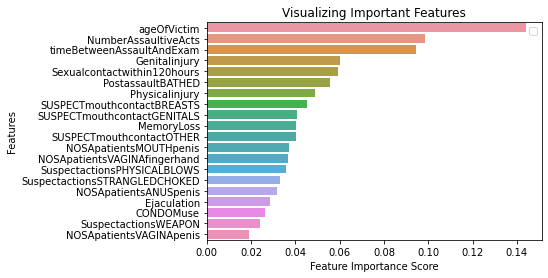

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
X=new_df[['ageOfVictim', 'timeBetweenAssaultAndExam','NumberAssaultiveActs','PostassaultBATHED','SUSPECTmouthcontactBREASTS','timeBetweenAssaultAndExam','Genitalinjury','Sexualcontactwithin120hours']]  # Removed feature "sepal length"
y=new_df['CODISNDISeligibleProfile']                                       
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=5) # 70% training and 30% test

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6416747809152873
